## Run this notebook

You can launch this notebook using mybinder, by clicking the button below.

<a href="https://mybinder.org/v2/gh/NASA-IMPACT/veda-docs/HEAD?labpath=notebooks/datasets/ocean-npp-timeseries-analysis.ipynb">
<img src="https://mybinder.org/badge_logo.svg" alt="Binder" title="A cute binder" width="150"/> 
</a>

## Approach

   1. Identify available dates and temporal frequency of observations for a given collection
   2. Pass STAC item into raster API `/stac/tilejson.json` endpoint
   3. Get time series statistics over available time period to identify seasonal trends
   4. Visualize peak by displaying the tile in `folium`
   5. Visualize time series of raster images
   

## About the Data

[Ocean Net Primary Production (NPP)](https://oceancolor.gsfc.nasa.gov/atbd/npp/) is the result of CO2 fixation, through photosynthesis, by marine phytoplankton which contain chlorophyll. It is the proportion of phytoplankton-sequestered carbon that enters the oceanic food web and supports a variety of marine life.  

## The Case Study - Walvis Bay, Namibia

Walvis Bay is home to Namibia's largest marine farming center and a well established commercial fishing industry. It's location in the nutrient-rich Benguela upwelling system of the Atlantic Ocean, means producers can rely on this area to cultivate an abundance of shellfish including oysters, mussels, and scallops.

Occasionally the nutrient-rich waters of the Atlantic produce higher than normal NPP levels, resulting in short-lived harmful algal blooms. This is often a result of both favorable temperatures and abundance of sufficient nutrients. The resulting algal blooms can have severe consequences causing massive fish kills, contaminating seafood with toxins and creating an unsafe environment for humans and marine life. Toxins accumulated in the shellfish organs can be subsequently transmitted to humans through consumption and resulting in serious health threats. 

In this example we explore the Ocean NPP dataset over the year 2020 to identify spatial and temporal patterns of Ocean NPP in the Walvis Bay area. 

## Querying the STAC API

In [1]:
import requests
from folium import Map, TileLayer

In [2]:
# Provife STAC and RASTER API endpoints
STAC_API_URL = "https://staging-stac.delta-backend.com"
RASTER_API_URL = "https://staging-raster.delta-backend.com"

# Declare collection of interest - Ocean NPP
collection_name = "MO_NPP_npp_vgpm"

In [3]:
# Fetch STAC collection
collection = requests.get(f"{STAC_API_URL}/collections/{collection_name}").json()
collection

{'id': 'MO_NPP_npp_vgpm',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://staging-stac.delta-backend.com/collections/MO_NPP_npp_vgpm/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.com/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.com/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.com/collections/MO_NPP_npp_vgpm'}],
 'title': '',
 'extent': {'spatial': {'bbox': [[-180, -90, 180, 90]]},
  'temporal': {'interval': [['2020-01-01T00:00:00Z',
     '2020-12-12T23:59:59Z']]}},
 'license': 'MIT',
 'summaries': {'datetime': ['2020-01-01T00:00:00Z', '2020-12-01T00:00:00Z'],
  'cog_default': {'max': 34561.35546875, 'min': 14.516647338867188}},
 'description': 'Ocean Net Primary Production (NPP): https://oceancolor.gsfc.nasa.gov/atbd/npp/',
 'item_assets': {'cog_default': {'typ

In [4]:
# Verify frequency of data available
collection["dashboard:time_density"]

'month'

In [5]:
# Get collection summary
collection["summaries"]

{'datetime': ['2020-01-01T00:00:00Z', '2020-12-01T00:00:00Z'],
 'cog_default': {'max': 34561.35546875, 'min': 14.516647338867188}}

Great, we can explore the year 2020 time series. Let's create a bounding box to explore the Walvis Bay area of interest (AOI) in Namibia

In [6]:
# Walvis Bay, Namibia
walvis_bay_aoi = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "coordinates": [
            [
                [13.686159004559698, -21.700046934333145],
                [13.686159004559698, -23.241974326585833],
                [14.753560168039911, -23.241974326585833],
                [14.753560168039911, -21.700046934333145],
                [13.686159004559698, -21.700046934333145],
            ]
        ],
        "type": "Polygon",
    },
}

Let's visualize the AOI we have just created using `folium` 

In [7]:
# We'll plug in the coordinates for a location
# central to the study area and a reasonable zoom level

import folium

m = Map(
    tiles="OpenStreetMap",
    location=[
        -22.421460,
        14.268801,
    ],
    zoom_start=8,
)

folium.GeoJson(walvis_bay_aoi, name="Walvis Bay").add_to(m)
m

Returning back to our STAC API requests, let's check how many total items are available. 

In [8]:
# Check total number of items available
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=100"
).json()["features"]
print(f"Found {len(items)} items")

Found 12 items


This makes sense is our collection is monthly, so we should have 12 total items.

In [9]:
# Explore one item to see what it contains
items[0]

{'id': 'A_202012.L3m_MO_NPP_npp_vgpm_4km',
 'bbox': [-180.0000050868518,
  -90.00000508655744,
  180.0000050868518,
  89.9999974571629],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.com/collections/MO_NPP_npp_vgpm'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.com/collections/MO_NPP_npp_vgpm'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.com/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://staging-stac.delta-backend.com/collections/MO_NPP_npp_vgpm/items/A_202012.L3m_MO_NPP_npp_vgpm_4km'}],
 'assets': {'cog_default': {'href': 's3://veda-data-store-staging/MO_NPP_npp_vgpm/A_202012.L3m_MO_NPP_npp_vgpm_4km.tif',
   'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
   'roles': ['data', 'layer'],
   'title': 'Default COG Layer',
   'description': 'Cloud opti

Now that we have explored the collection metadata by querying the STAC API, we can use the RASTER API to access the data itself.

In [10]:
# the bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
def generate_stats(item, geojson):
    result = requests.post(
        f"{RASTER_API_URL}/cog/statistics",
        params={"url": item["assets"]["cog_default"]["href"]},
        json=geojson,
    ).json()
    return {
        **result["properties"],
        "start_datetime": item["properties"]["start_datetime"],
    }

In [11]:
%%time
stats = [generate_stats(item, walvis_bay_aoi) for item in items]

CPU times: user 813 ms, sys: 42.7 ms, total: 856 ms
Wall time: 13.2 s


With the function provided above, we can generate statistics for our AOI. In the example below, we'll explore sample statistics available from one of the tiles. 

In [12]:
stats[0]

{'statistics': {'1': {'min': 2288.525146484375,
   'max': 19800.787109375,
   'mean': 4803.135537190083,
   'count': 605.0,
   'sum': 2905897.0,
   'std': 2175.5772113693283,
   'median': 4171.0107421875,
   'majority': 4321.17041015625,
   'minority': 2288.525146484375,
   'unique': 595.0,
   'histogram': [[282.0, 207.0, 73.0, 22.0, 11.0, 1.0, 3.0, 1.0, 0.0, 5.0],
    [2288.525146484375,
     4039.75146484375,
     5790.9775390625,
     7542.20361328125,
     9293.4296875,
     11044.65625,
     12795.8828125,
     14547.1083984375,
     16298.3349609375,
     18049.560546875,
     19800.787109375]],
   'valid_percent': 62.89,
   'masked_pixels': 357.0,
   'valid_pixels': 605.0,
   'percentile_98': 10588.860703124998,
   'percentile_2': 2742.223876953125}},
 'start_datetime': '2020-12-01T00:00:00'}

In [13]:
import pandas as pd


def clean_stats(stats_json) -> pd.DataFrame:
    df = pd.json_normalize(stats_json)
    df.columns = [col.replace("statistics.1.", "") for col in df.columns]
    df["date"] = pd.to_datetime(df["start_datetime"])
    return df


df = clean_stats(stats)

## Visualizing the Data as a Time Series

We can now explore the full Ocean NPP time series available (January-December 2020) for the Walvis Bay area of Namibia. We can plot the data set using the code below: 

Text(0.5, 1.0, 'Ocean NPP Values for Walvis Bay, Namibia (2020)')

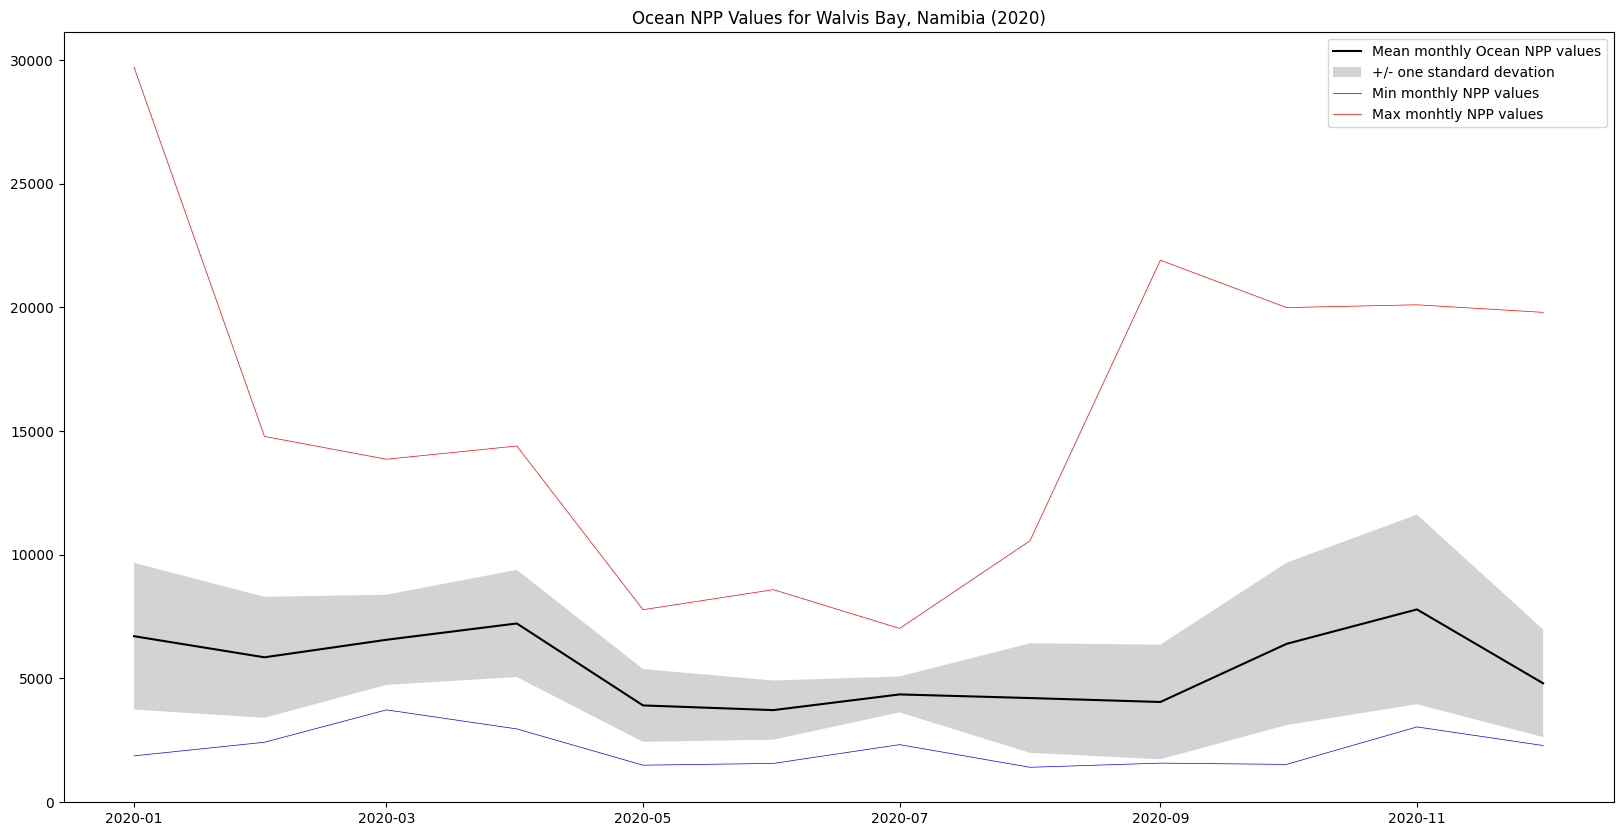

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))

plt.plot(df["date"], df["mean"], "black", label="Mean monthly Ocean NPP values")

plt.fill_between(
    df["date"],
    df["mean"] + df["std"],
    df["mean"] - df["std"],
    facecolor="lightgray",
    interpolate=False,
    label="+/- one standard devation",
)

plt.plot(
    df["date"],
    df["min"],
    color="blue",
    linestyle="-",
    linewidth=0.5,
    label="Min monthly NPP values",
)
plt.plot(
    df["date"],
    df["max"],
    color="red",
    linestyle="-",
    linewidth=0.5,
    label="Max monhtly NPP values",
)

plt.legend()
plt.title("Ocean NPP Values for Walvis Bay, Namibia (2020)")

Here, we observe the seasonal variability in Ocean NPP for the Walvis Bay area. The larger peaks in the max values suggests the intensity of these events may vary spatially. Let's explore one of the time steps (e.g., October) where there are higher maximum monthly NPP values to see if this is the case.

**Important note**: Keep in mind that the size and extent of your AOI will influence the 'signal' of your time series. If the phenomena you are investigating displays greater spatial variability a larger AOI will provide more 'noise' making it more difficult to detect.

## Visualizing the Raster Imagery

Let's first explore a single tile during one of the relative peaks in October, where we observe an increased sustained peak in NPP values.

In [15]:
print(items[2]["properties"]["start_datetime"])

2020-10-01T00:00:00


In [16]:
rescale_values = collection["summaries"]["cog_default"]
rescale_values

{'max': 34561.35546875, 'min': 14.516647338867188}

In [17]:
october_tile = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[2]['collection']}&item={items[2]['id']}"
    "&assets=cog_default"
    "&color_formula=gamma+r+1.05&colormap_name=viridis"
    f"&rescale={rescale_values['min']},{rescale_values['max']}",
).json()
october_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://staging-raster.delta-backend.com/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=MO_NPP_npp_vgpm&item=A_202010.L3m_MO_NPP_npp_vgpm_4km&assets=cog_default&color_formula=gamma+r+1.05&colormap_name=viridis&rescale=14.516647338867188%2C34561.35546875'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0000050868518,
  -90.00000508655744,
  180.0000050868518,
  89.9999974571629],
 'center': [0.0, -3.814697265625e-06, 0]}

In [18]:
# Use bbox initial zoom and map
# Set up a map located w/in event bounds
import folium

m = Map(
    tiles="OpenStreetMap",
    location=[
        -22.421460,
        14.268801,
    ],
    zoom_start=8,
)

map_layer = TileLayer(
    tiles=october_tile["tiles"][0],
    attr="VEDA",
)

map_layer.add_to(m)

m

From the image above, we see higher Ocean NPP values (displayed in teal) located in and around Walvis Bay and the surrounding shorelines - highlighting areas of concern for the local shellfish industry. 

## Visualizing the raster time  series
Now we will look at each of the raster tiles that make up this time series to explore the spatial and temporal patterns of Ocean NPP observed in Walvis Bay throughout 2020.

We used the code below to examine the tiles and the order in which they are presented. 

In [19]:
import matplotlib.pyplot as plt

for item in items:
    tiles = requests.get(
        f"{RASTER_API_URL}/stac/tilejson.json?collection={item['collection']}&item={item['id']}"
        "&assets=cog_default"
        "&color_formula=gamma+r+1.05&colormap_name=viridis"
        f"&rescale={rescale_values['min']},{rescale_values['max']}",
    ).json()
    print(tiles["tiles"])

['https://staging-raster.delta-backend.com/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=MO_NPP_npp_vgpm&item=A_202012.L3m_MO_NPP_npp_vgpm_4km&assets=cog_default&color_formula=gamma+r+1.05&colormap_name=viridis&rescale=14.516647338867188%2C34561.35546875']
['https://staging-raster.delta-backend.com/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=MO_NPP_npp_vgpm&item=A_202011.L3m_MO_NPP_npp_vgpm_4km&assets=cog_default&color_formula=gamma+r+1.05&colormap_name=viridis&rescale=14.516647338867188%2C34561.35546875']
['https://staging-raster.delta-backend.com/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=MO_NPP_npp_vgpm&item=A_202010.L3m_MO_NPP_npp_vgpm_4km&assets=cog_default&color_formula=gamma+r+1.05&colormap_name=viridis&rescale=14.516647338867188%2C34561.35546875']
['https://staging-raster.delta-backend.com/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=MO_NPP_npp_vgpm&item=A_202009.L3m_MO_NPP_npp_vgpm_4km&assets=cog_default&color_formula=gamma+r+1.05&colormap_nam

Since we found the tiles to be presented in reverse time order, we'll revise this in the code below. We'll use `reversed()` to do so.  

January 2020


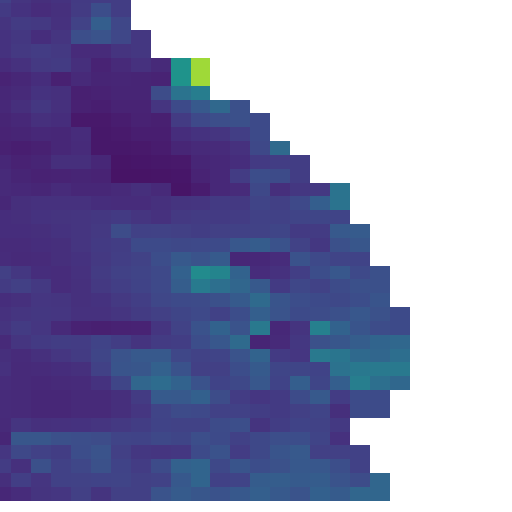

February 2020


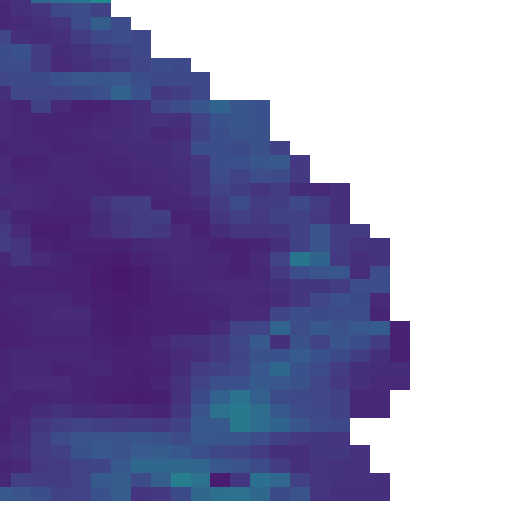

March 2020


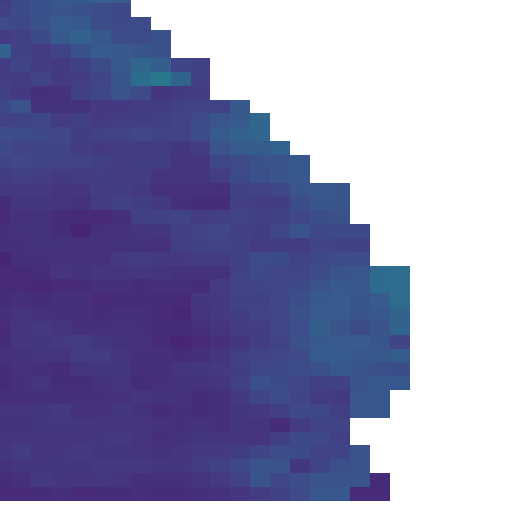

April 2020


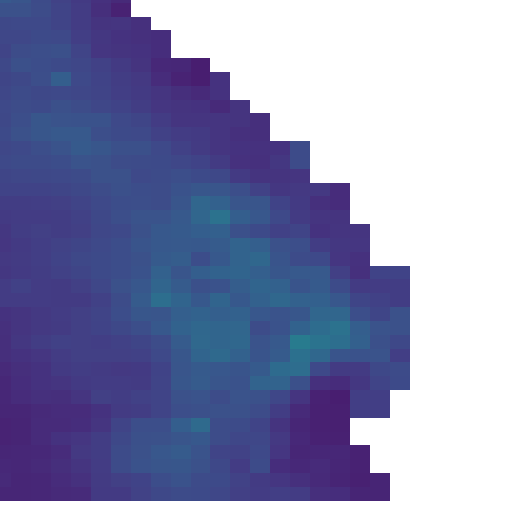

May 2020


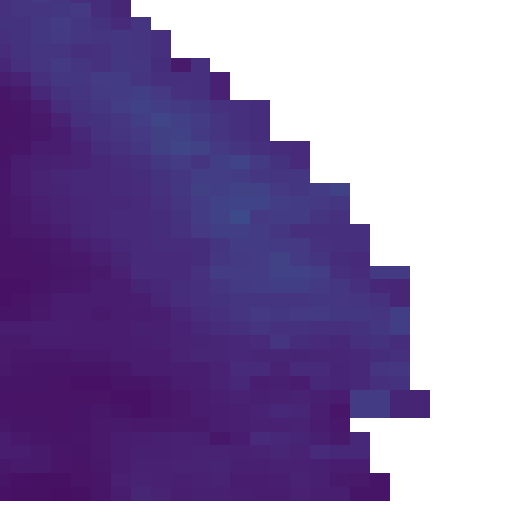

June 2020


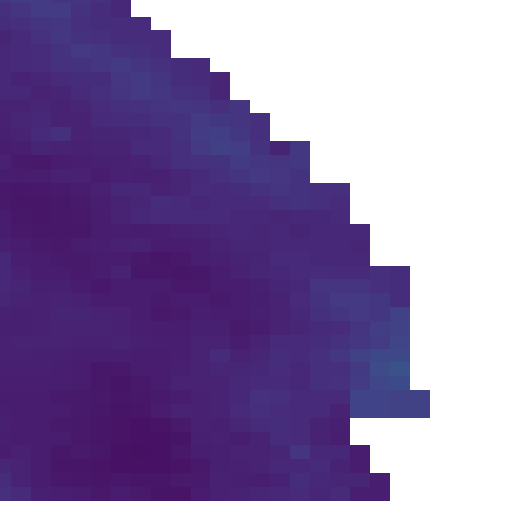

July 2020


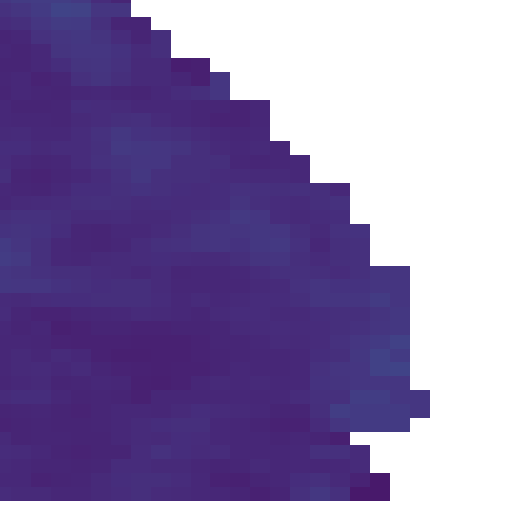

August 2020


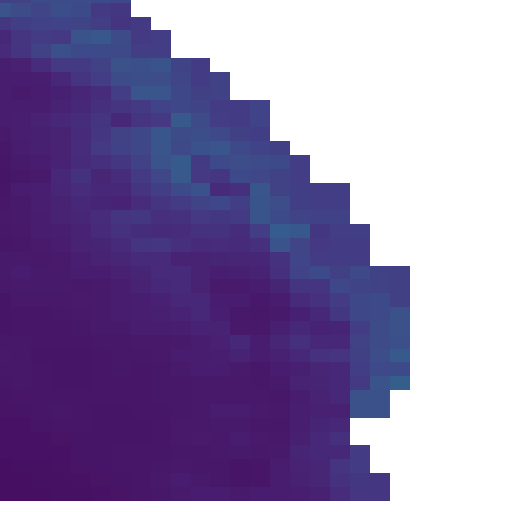

September 2020


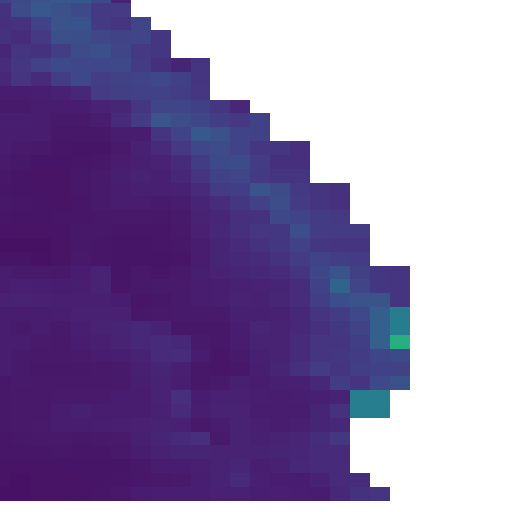

October 2020


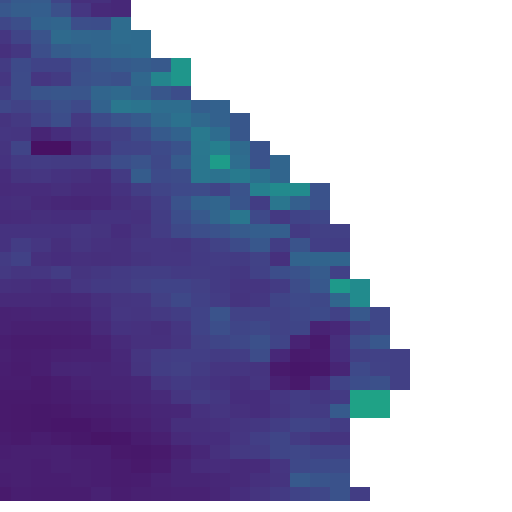

November 2020


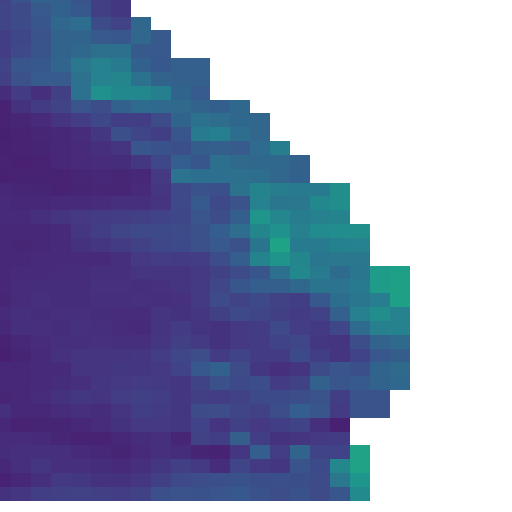

December 2020


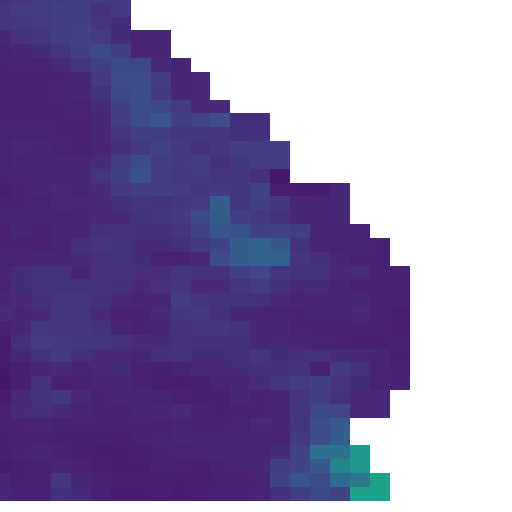

In [20]:
import tempfile
from datetime import datetime
from IPython.display import display, Image

COG_DEFAULT = [
    x
    for x in requests.get(f"{STAC_API_URL}/collections").json()["collections"]
    if x["id"] == "MO_NPP_npp_vgpm"
][0]["summaries"]["cog_default"]


for item in reversed(items):
    image_bytes = requests.post(
        f"{RASTER_API_URL}/cog/crop",
        params={
            "format": "png",
            "height": 512,
            "width": 512,
            "url": item["assets"]["cog_default"]["href"],
            "rescale": f"{COG_DEFAULT['min']},{COG_DEFAULT['max']}",
            "colormap_name": "viridis",
        },
        json=walvis_bay_aoi,
    ).content

    # formating the datetime to make for easier reading
    datetime_str = item["properties"]["start_datetime"]
    datetime_object = datetime.strptime(datetime_str, "%Y-%m-%dT%H:%M:%S")
    print(datetime_object.strftime("%B %Y"))

    display(Image(image_bytes, height=512, width=512))

## Summary
In this case study we have successfully visualized the spatial and temporal variability of Ocean NPP values in the Benguela Current, which displays a seasonal pattern of peaking in the October, November, December, and January months when favorable temperatures and nutrient conditions are present. 